<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/pix2pix/huggingface_pix2pixzero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install git+https://github.com/huggingface/diffusers.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-219dgo89
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-219dgo89
  Resolved https://github.com/huggingface/diffusers.git to commit 39a3c77e0d4a22de189b02398cf2d003d299b4ae
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.14.0.dev0-py3-none-any.whl size=716030 sha256=66d0b5118190c5a3f3db2a91538c2a922a1627c0a1377b78cdd3289dc1849ced
  Stored in directory: /tmp/pip-ephem-wheel-cache-f5f2mkem/wheels/28/16/cf/d8d37579fd1e7edb978252d850ec9328b055a7582ddfae3b87
Successfully built diffusers


In [ ]:
!pip install transformers

In [ ]:
import requests
import torch

from diffusers import DDIMScheduler, StableDiffusionPix2PixZeroPipeline


def download(embedding_url, local_filepath):
    r = requests.get(embedding_url)
    with open(local_filepath, "wb") as f:
        f.write(r.content)


model_ckpt = "CompVis/stable-diffusion-v1-4"
pipeline = StableDiffusionPix2PixZeroPipeline.from_pretrained(
    model_ckpt, conditions_input_image=False, torch_dtype=torch.float16
)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.to("cuda")

prompt = "a high resolution painting of a cat in the style of van gough"
src_embs_url = "https://github.com/pix2pixzero/pix2pix-zero/raw/main/assets/embeddings_sd_1.4/cat.pt"
target_embs_url = "https://github.com/pix2pixzero/pix2pix-zero/raw/main/assets/embeddings_sd_1.4/dog.pt"

for url in [src_embs_url, target_embs_url]:
    download(url, url.split("/")[-1])

src_embeds = torch.load(src_embs_url.split("/")[-1])
target_embeds = torch.load(target_embs_url.split("/")[-1])

images = pipeline(
    prompt,
    source_embeds=src_embeds,
    target_embeds=target_embeds,
    num_inference_steps=50,
    cross_attention_guidance_amount=0.15,
).images
images[0].save("edited_image_dog.png")

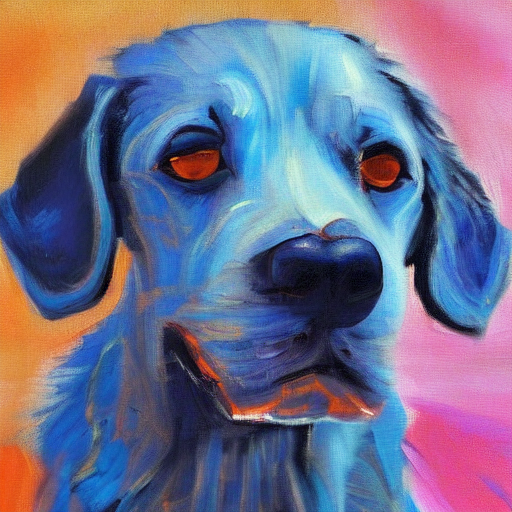

In [2]:
from PIL import Image
display(Image.open("edited_image_dog.png"))

In [ ]:
# install accelerate with latest version
!pip install git+https://github.com/huggingface/accelerate

In [1]:
#@title Base on input image
import torch
from transformers import BlipForConditionalGeneration, BlipProcessor
from diffusers import DDIMScheduler, DDIMInverseScheduler, StableDiffusionPix2PixZeroPipeline

captioner_id = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(captioner_id)
model = BlipForConditionalGeneration.from_pretrained(captioner_id, torch_dtype=torch.float16, low_cpu_mem_usage=True)

sd_model_ckpt = "CompVis/stable-diffusion-v1-4"
pipeline = StableDiffusionPix2PixZeroPipeline.from_pretrained(
    sd_model_ckpt,
    caption_generator=model,
    caption_processor=processor,
    torch_dtype=torch.float16,
    safety_checker=None,
)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_model_cpu_offload()

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_pix2pix_zero.StableDiffusionPix2PixZeroPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [2]:
# get caption
import requests
from PIL import Image

img_url = "https://github.com/pix2pixzero/pix2pix-zero/raw/main/assets/test_images/cats/cat_6.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB").resize((512, 512))
caption = pipeline.generate_caption(raw_image)

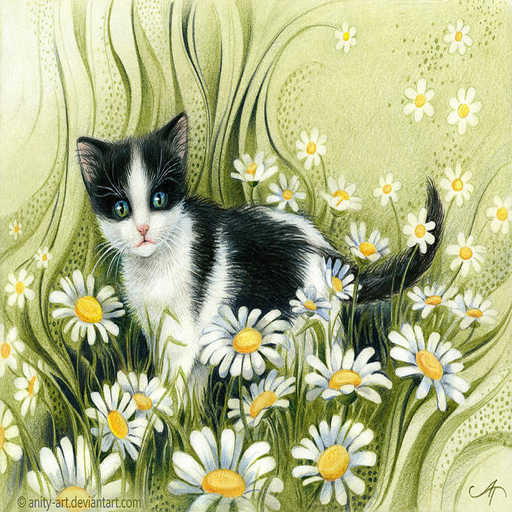

'a photography of a cat with flowers and dai dai daie - daie - daie kasaii'

In [4]:
display(raw_image, caption)

In [5]:
# we employ the generated caption and the input image to get the inverted noise
generator = torch.manual_seed(0)
inv_latents = pipeline.invert(caption, image=raw_image, generator=generator).latents

  0%|          | 0/48 [00:00<?, ?it/s]

In [6]:
# See the "Generating source and target embeddings" section below to
# automate the generation of these captions with a pre-trained model like Flan-T5 as explained below.
source_prompts = ["a cat sitting on the street", "a cat playing in the field", "a face of a cat"]
target_prompts = ["a dog sitting on the street", "a dog playing in the field", "a face of a dog"]

source_embeds = pipeline.get_embeds(source_prompts, batch_size=2)
target_embeds = pipeline.get_embeds(target_prompts, batch_size=2)

In [8]:
source_embeds.shape

torch.Size([1, 77, 768])

In [9]:
image = pipeline(
    caption,
    source_embeds=source_embeds,
    target_embeds=target_embeds,
    num_inference_steps=50,
    cross_attention_guidance_amount=0.15,
    generator=generator,
    latents=inv_latents,
    negative_prompt=caption,
).images[0]
image.save("edited_image.png")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

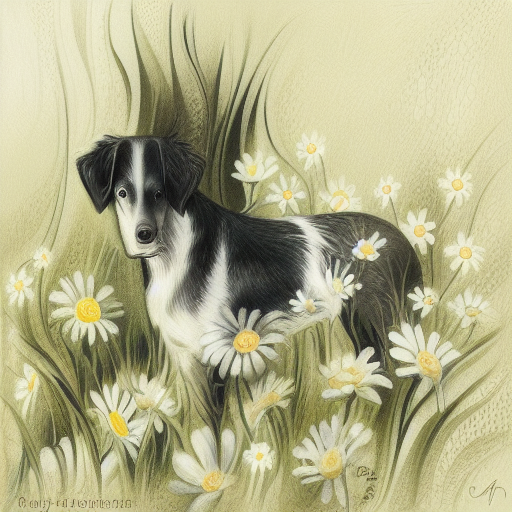

In [10]:
display(Image.open("edited_image.png"))

In [1]:
#@title generate source embedding and target embedding with flan
import torch
from transformers import AutoTokenizer, T5ForConditionalGeneration

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto", torch_dtype=torch.float16)

In [2]:
# construct starting prompt
source_concept = "cat"
target_concept = "dog"

source_text = f"Provide a caption for images containing a {source_concept}. "
"The captions should be in English and should be no longer than 150 characters."

target_text = f"Provide a caption for images containing a {target_concept}. "
"The captions should be in English and should be no longer than 150 characters."

'The captions should be in English and should be no longer than 150 characters.'

In [3]:
def generate_captions(input_prompt):
    input_ids = tokenizer(input_prompt, return_tensors="pt").input_ids.to("cuda")

    outputs = model.generate(
        input_ids, temperature=0.8, num_return_sequences=16, do_sample=True, max_new_tokens=128, top_k=10
    )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [4]:
source_captions = generate_captions(source_text)
target_captions = generate_captions(target_text)

In [ ]:
# load stable diffusionpix2pix2zero pipeline
from diffusers import StableDiffusionPix2PixZeroPipeline 

pipeline = StableDiffusionPix2PixZeroPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16
)
pipeline = pipeline.to("cuda")
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder

In [8]:
# compute embeddings
import torch 

def embed_captions(sentences, tokenizer, text_encoder, device="cuda"):
    with torch.no_grad():
        embeddings = []
        for sent in sentences:
            text_inputs = tokenizer(
                sent,
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            prompt_embeds = text_encoder(text_input_ids.to(device), attention_mask=None)[0]
            embeddings.append(prompt_embeds)
    return torch.concatenate(embeddings, dim=0).mean(dim=0).unsqueeze(0)

source_embeddings = embed_captions(source_captions, tokenizer, text_encoder)
target_embeddings = embed_captions(target_captions, tokenizer, text_encoder)

In [9]:
from diffusers import DDIMScheduler

pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

prompt = "a high resolution painting of a cat in the style of van gough"

images = pipeline(
    prompt,
    source_embeds=source_embeddings,
    target_embeds=target_embeddings,
    num_inference_steps=50,
    cross_attention_guidance_amount=0.15,
).images
images[0].save("edited_image_dog_blip.png")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]